# Portfolio Optimization using Monte Carlo Methods

### Overview
This notebook applies Modern Portfolio Theory (MPT) and Monte Carlo simulation to construct an optimal investment portfolio from several randomly selected stocks. The period spans from January 2019 to December 2025.

### Methodology

1. **Data Collection & Processing**

- Historical Price Data: Retrieved 7 years of daily adjusted close prices using yfinance API
- Returns Calculation: Computed logarithmic returns for statistical analysis
- Statistical Measures: Calculated annualized returns, volatility, and correlation matrices

2. **Monte Carlo Simulation**

- Simulation Size: Generated 50,000 random portfolio combinations
- Purpose: Map the efficient frontier by exploring various weight allocations
- Risk-Return Trade-off: Evaluated portfolio performance across different risk levels

3. **Portfolio Optimization**
- Objective Function: Maximize Sharpe Ratio (risk-adjusted return)
- Optimization Method: Sequential Least Squares Programming (SLSQP)
- Constraints:
  - Portfolio weights sum to 100%
  - No short selling (weights between 0% and 100%)
- Risk-Free Rate: 3.6% annual rate used as benchmark (use Dec 20, 2025 US treasury yield data)

### Risk Analysis

1. **Correlation Insights**
   
- Diversification Benefits: The correlation matrix reveals varying relationships between stocks, enabling risk reduction through diversification
- Sector Exposure: Mix of technology, retail, industrial, and financial sectors provides balanced exposure
- Volatility Management: Portfolio volatility is lower than most individual stock volatilities due to diversification effects
  
2. **Efficient Frontier Visualization**

The Monte Carlo simulation mapped 50,000 portfolios, revealing:
-  Risk-Return Spectrum: Clear trade-off between expected returns and volatility
- Optimal Position: The optimized portfolio sits on the efficient frontier, offering maximum return for its risk level
- Sharpe Ratio Gradient: Color-coded visualization shows risk-adjusted performance across all simulated portfolios

### Specifications

- Analysis Period: January 2019 - December 2025
- Trading Days: 252 days per year (annualization factor)
- Optimization Algorithm: SLSQP (Sequential Least Squares Programming)
- Monte Carlo Iterations: 50,000 simulations
- Risk-Free Rate: 3.6% (used for Sharpe Ratio calculation)
- Data Source: Yahoo Finance via yfinance API


## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as optimization


# Configuration
import warnings
warnings.filterwarnings('ignore')

# Set consistent plotting style
sns.set_style('whitegrid')
plt.style.use('bmh')

# Plotting configuration
plt.rcParams['figure.figsize'] = (13.5, 7)
plt.rcParams['font.size'] = 10

# Set random seed for reproducibility
RANDOM_SEED = 3407
np.random.seed(RANDOM_SEED)

# Display settings
pd.set_option('display.precision', 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)


print(f" Random seed set to: {RANDOM_SEED}")

 Random seed set to: 3407


## 2. Data Collection and Preprocessing

*  the daily logarithmic returns: $$ R_i = log (r_{i}/r_{i-1}) $$


In [2]:
# Configuration
STOCKS = ['ADBE', 'BIIB', 'AEP', 'TPL', 'BALL', 'DASH', 'DUK', 'IFF', 'SO', 'TJX', 'UNH', 'AXON', 'JPM', 'MAR']
STOCKS = ['AEP', 'TPL', 'BALL', 'A', 'SO', 'TJX', 'UNH', 'AXON', 'JPM']
START_DATE = '2019-01-01'
END_DATE = '2026-01-01'
RISK_FREE_RATE = 0.036
NUM_PORTFOLIOS = 50_000
TRADING_DAYS = 252

In [3]:
def download_stock_data(tickers, start_date, end_date):
    """
    Download historical stock data using yfinance
    
    Parameters:
    -----------
    tickers : list
        List of stock ticker symbols
    start_date : str
        Start date in format 'YYYY-MM-DD'
    end_date : str
        End date in format 'YYYY-MM-DD'
    
    Returns:
    --------
    tuple : (adjusted_close_data, complete_data)
    """
    try:
        # Download complete data
        complete_data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    
        if complete_data.empty:
            raise ValueError("No data downloaded. Check tickers and date range")
        
        if isinstance(complete_data.columns, pd.MultiIndex):
            adj_close_data = complete_data["Adj Close"] if "Adj Close" in complete_data.columns.get_level_values(0) else complete_data["Close"]
        else:
            adj_close_data = complete_data["Adj Close"] if "Adj Close" in complete_data.columns else complete_data["Close"]
        
        adj_close_data = adj_close_data.dropna(how="all", axis=0).dropna(how="all", axis=1)
        # adj_close_data.columns = tickers
            
        print(f'Successfully downloaded data for {len(tickers)} stocks')
        print(f'Date range: {adj_close_data.index[0].date()} to {adj_close_data.index[-1].date()}')
        print(f'Total trading days: {len(adj_close_data)}')
        
        return adj_close_data, complete_data
    
    except Exception as e:
        print(f'Error downloading data: {e}')
        return None, None

def calculate_returns(price_data):
    """
    Calculate daily and logarithmic returns from price data
    
    Parameters:
    -----------
    price_data : DataFrame
        DataFrame containing adjusted close prices
    
    Returns:
    --------
    tuple : (daily_returns, log_returns)
    """
    # Simple daily returns
    daily_returns = price_data.pct_change()
    
    # Logarithmic returns
    log_returns = np.log(price_data / price_data.shift(1))
    
    # Remove first row (NaN values)
    daily_returns = daily_returns.dropna()
    log_returns = log_returns.dropna()
    
    return daily_returns, log_returns

In [4]:
# Download data
print('Downloading stock data...')
print('=' * 60)
data, complete_data = download_stock_data(STOCKS, START_DATE, END_DATE)

# Calculate returns
daily_returns, log_returns = calculate_returns(data)

print('\n' + '=' * 60)
print('Data processing completed!')
print('=' * 60)

Successfully downloaded data for 9 stocks
Date range: 2019-01-02 to 2025-12-19
Total trading days: 1753

Data processing completed!


In [5]:
complete_data.head()

Price           Close                                                                                            \
Ticker              A        AEP       AXON       BALL        JPM         SO        TJX         TPL         UNH   
Date                                                                                                              
2019-01-02  62.553902  56.979637  45.110001  41.297958  81.616707  33.165634  40.638279  169.225204  217.128174   
2019-01-03  60.249428  56.846844  43.290001  40.918926  80.456795  33.635956  40.210606  169.709305  211.207031   
2019-01-04  62.334877  57.370243  46.009998  42.148514  83.422859  33.916641  41.311646  176.928680  213.677155   
2019-01-07  63.658512  57.049957  48.150002  42.934353  83.480850  33.840767  42.421776  185.238739  214.087326   
2019-01-08  64.591736  57.753017  49.410000  43.368877  83.323456  34.804192  43.049644  187.506744  216.949799   

Price            High                                                                                            \
Ticker              A        AEP       AXON       BALL        JPM         SO        TJX         TPL         UNH   
Date                                                                                                              
2019-01-02  63.391887  58.284215  45.119999  41.926627  82.002972  33.340110  40.984060  171.536547  219.678532   
2019-01-03  62.639596  57.542104  44.700001  41.630801  81.931545  33.901462  40.829371  172.819976  217.119214   
2019-01-04  62.801482  57.370243  46.209999  42.592279  83.621700  33.931813  41.584629  181.082215  217.101421   
2019-01-07  64.210824  57.190571  48.709999  43.563022  84.069093  33.954554  42.885851  188.557613  215.781614   
2019-01-08  64.953592  57.846762  49.910000  43.775662  84.359096  34.872465  43.167935  190.641312  218.287399   

Price             Low                                                                                            \
Ticker              A        AEP       AXON       BALL        JPM         SO        TJX         TPL         UNH   
Date                                                                                                              
2019-01-02  62.182521  56.612479  42.619999  41.048343  78.847118  32.816680  40.165106  156.848262  215.326869   
2019-01-03  59.040058  56.479692  42.419998  40.558367  80.108821  33.195971  39.855726  163.446120  210.564982   
2019-01-04  61.030279  56.448444  43.189999  41.316451  81.426143  33.408386  40.711080  172.356797  212.945940   
2019-01-07  62.477713  56.589061  46.389999  41.935881  82.610910  33.514572  41.238844  179.289316  212.437614   
2019-01-08  63.515678  56.784350  48.650002  43.193221  82.478376  33.757334  41.875811  186.764183  213.757405   

Price            Open                                                                                            \
Ticker              A        AEP       AXON       BALL        JPM         SO        TJX         TPL         UNH   
Date                                                                                                              
2019-01-02  63.325229  58.284215  42.990002  41.834177  78.855331  33.294593  40.247001  159.050544  218.474686   
2019-01-03  62.401532  56.979650  44.340000  41.076095  81.724417  33.195971  40.574586  167.336709  217.119214   
2019-01-04  61.030279  56.495314  43.950001  41.482864  82.113809  33.469072  40.774776  174.777200  213.837674   
2019-01-07  62.506280  56.979653  46.450001  42.176253  83.207440  33.764906  41.238844  179.289316  214.372674   
2019-01-08  64.363188  56.964019  48.980000  43.248690  84.201677  33.840780  42.585569  188.017712  216.093742   

Price        Volume                                                                           
Ticker            A      AEP     AXON     BALL       JPM       SO       TJX     TPL      UNH  
Date                                                                                          
2019-01-02  2113300  2679600  1

In [6]:
data.head()

Ticker,A,AEP,AXON,BALL,JPM,SO,TJX,TPL,UNH
Date,,,,,,,,,
2019-01-02,62.553902,56.979637,45.110001,41.297958,81.616707,33.165634,40.638279,169.225204,217.128174
2019-01-03,60.249428,56.846844,43.290001,40.918926,80.456795,33.635956,40.210606,169.709305,211.207031
2019-01-04,62.334877,57.370243,46.009998,42.148514,83.422859,33.916641,41.311646,176.928680,213.677155
2019-01-07,63.658512,57.049957,48.150002,42.934353,83.480850,33.840767,42.421776,185.238739,214.087326
2019-01-08,64.591736,57.753017,49.410000,43.368877,83.323456,34.804192,43.049644,187.506744,216.949799


In [7]:
log_returns.head()

Ticker,A,AEP,AXON,BALL,JPM,SO,TJX,TPL,UNH
Date,,,,,,,,,
2019-01-03,-0.037536,-0.002333,-0.041182,-0.009220,-0.014314,0.014081,-0.010580,0.002857,-0.027649
2019-01-04,0.034028,0.009165,0.060937,0.029607,0.036202,0.008310,0.027014,0.041660,0.011627
2019-01-07,0.021012,-0.005598,0.045462,0.018473,0.000695,-0.002240,0.026517,0.045899,0.001918
2019-01-08,0.014553,0.012248,0.025832,0.010070,-0.001887,0.028072,0.014692,0.012169,0.013282
2019-01-09,0.020718,-0.007603,0.017057,0.003830,-0.001692,-0.008537,-0.000846,-0.028580,0.001437


In [8]:
# Display basic statistics
print('\n' + '=' * 60)
print('BASIC STATISTICS - ADJUSTED CLOSE PRICES')
print('=' * 60)
print(data.describe())


BASIC STATISTICS - ADJUSTED CLOSE PRICES
Ticker            A          AEP         AXON         BALL          JPM           SO          TJX          TPL  \
count   1753.000000  1753.000000  1753.000000  1753.000000  1753.000000  1753.000000  1753.000000  1753.000000   
mean     117.061637    80.613336   238.034147    63.999895   150.216837    61.881266    77.812291   539.317602   
std       27.014402    13.407263   204.027421    13.241804    62.806233    15.637698    28.836212   334.332231   
min       60.249428    56.831100    43.290001    40.918926    67.407677    33.165634    34.134007    95.227608   
25%       96.890572    71.573685    93.220001    53.209583   105.164490    49.622452    55.825249   236.847366   
50%      123.645241    76.434212   170.899994    61.200500   133.229446    59.854019    65.787315   479.687103   
75%      136.761169    87.224785   289.209991    73.367111   183.131134    69.048286    95.208221   674.678528   
max      174.067612   123.769997   870.969971 

## 3. Data Visualization

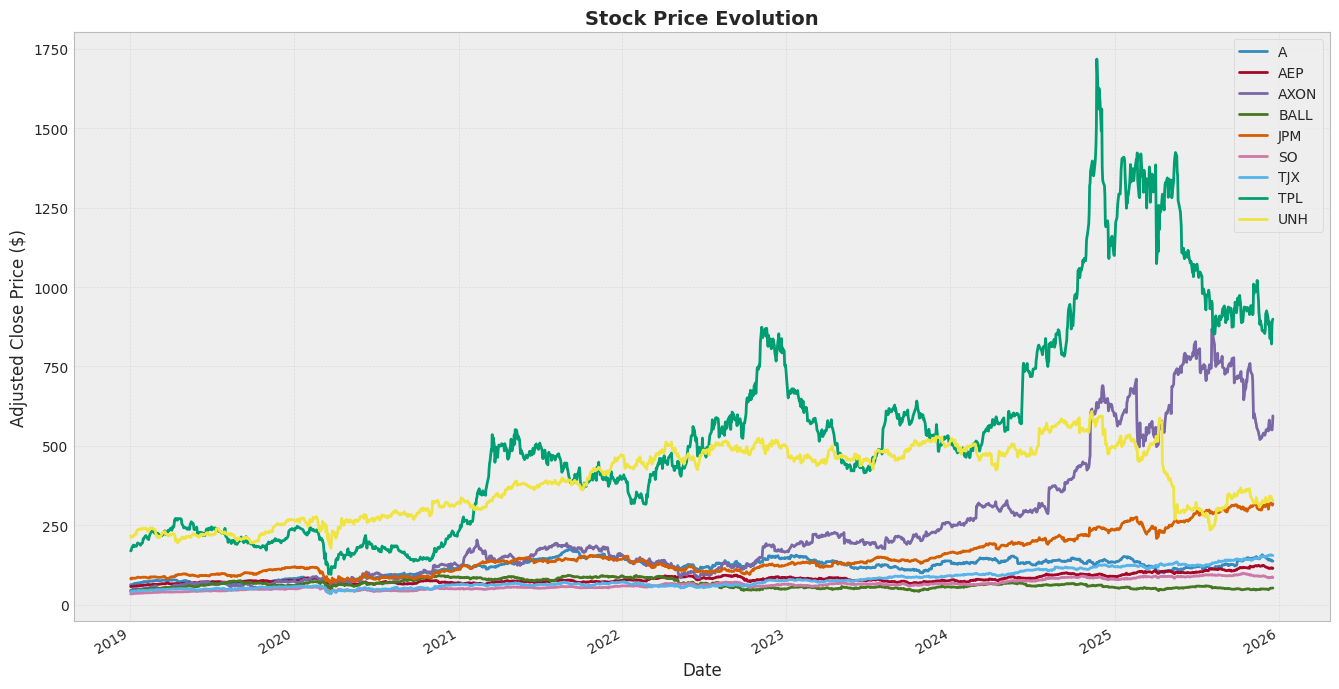

In [9]:
# Price evolution
data.plot()
plt.ylabel('Adjusted Close Price ($)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Stock Price Evolution', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

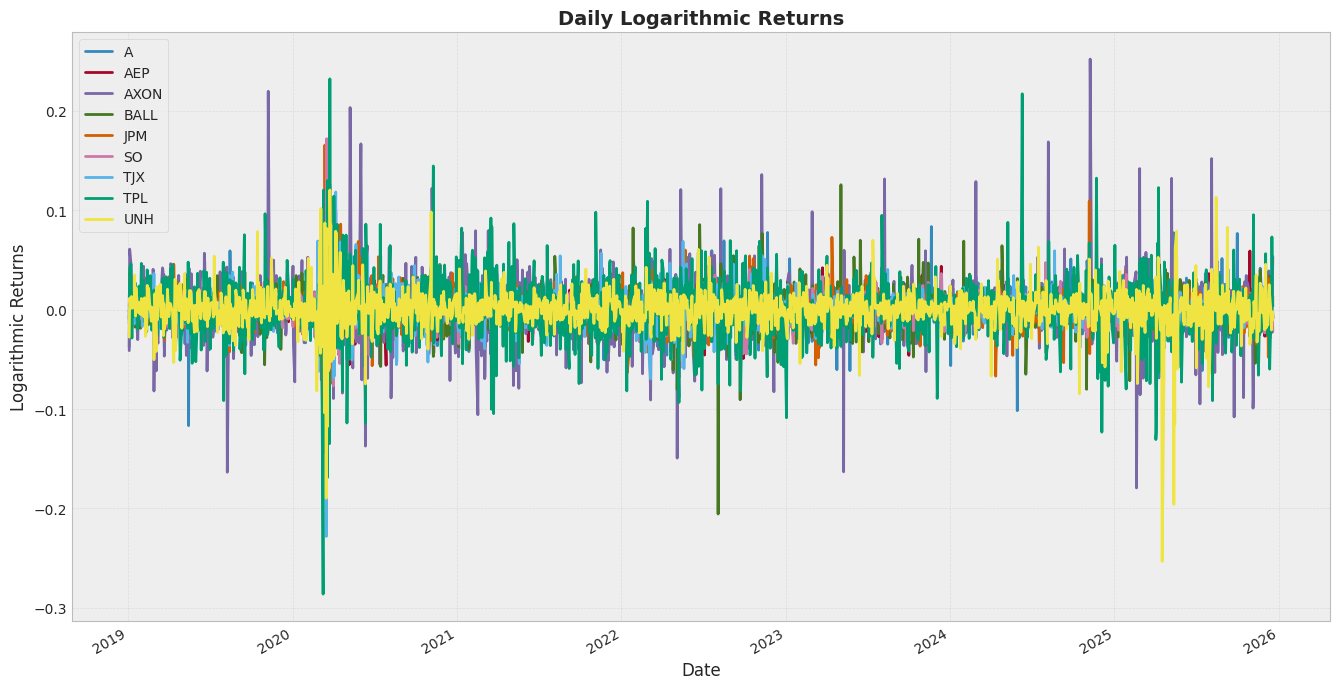

In [10]:
# Returns evolution
log_returns.plot()
plt.ylabel('Logarithmic Returns', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Daily Logarithmic Returns', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

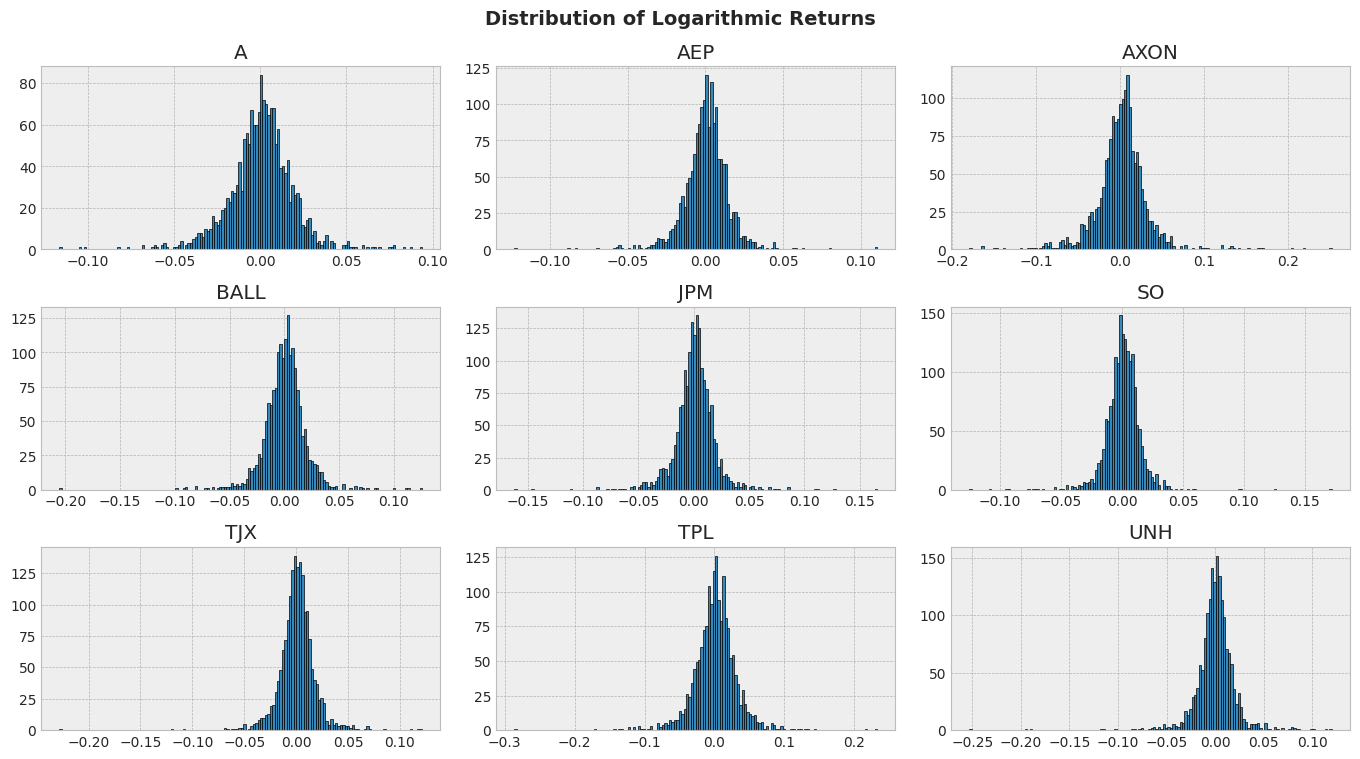

In [11]:
# Returns distribution
log_returns.hist(figsize=(13.7, 7.7), bins=150, edgecolor='black', linewidth=0.5)
plt.suptitle('Distribution of Logarithmic Returns', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Statistical Analysis

compute annualized return of each company:
- compute the mean and using $ \mu^{Annual} = 252\\ \mu$, where 252 is the number or trading days by year.
- compute the anualized covariance matrix as $ \sigma_{ij}^{Annual}=252\\ \sigma_{ij}$


In [12]:
print('=' * 60)
print('ANNUALIZED RETURNS')
print('=' * 60)
annualized_returns = log_returns.mean() * TRADING_DAYS
for stock, ret in annualized_returns.items():
    print(f'{stock:6s}: {ret:7.2%}')

print('\n' + '=' * 60)
print('ANNUALIZED VOLATILITY')
print('=' * 60)
annualized_volatility = log_returns.std() * np.sqrt(TRADING_DAYS)
for stock, vol in annualized_volatility.items():
    print(f'{stock:6s}: {vol:7.2%}')

print('\n' + '=' * 60)
print('ANNUALIZED COVARIANCE MATRIX')
print('=' * 60)
print(log_returns.cov() * TRADING_DAYS)

ANNUALIZED RETURNS
A     :  11.30%
AEP   :  10.04%
AXON  :  37.08%
BALL  :   3.32%
JPM   :  19.53%
SO    :  13.58%
TJX   :  19.22%
TPL   :  24.02%
UNH   :   5.91%

ANNUALIZED VOLATILITY
A     :  29.32%
AEP   :  22.85%
AXON  :  49.22%
BALL  :  30.81%
JPM   :  29.88%
SO    :  23.97%
TJX   :  28.60%
TPL   :  49.82%
UNH   :  32.96%

ANNUALIZED COVARIANCE MATRIX
Ticker         A       AEP      AXON      BALL       JPM        SO       TJX       TPL       UNH
Ticker                                                                                          
A       0.085971  0.020719  0.046744  0.038316  0.039836  0.023911  0.033669  0.042090  0.030729
AEP     0.020719  0.052204  0.012309  0.027890  0.020711  0.044698  0.022571  0.012531  0.022409
AXON    0.046744  0.012309  0.242236  0.030756  0.045170  0.014808  0.041410  0.064452  0.025661
BALL    0.038316  0.027890  0.030756  0.094923  0.029059  0.031905  0.030748  0.023243  0.023181
JPM     0.039836  0.020711  0.045170  0.029059  0.089309  

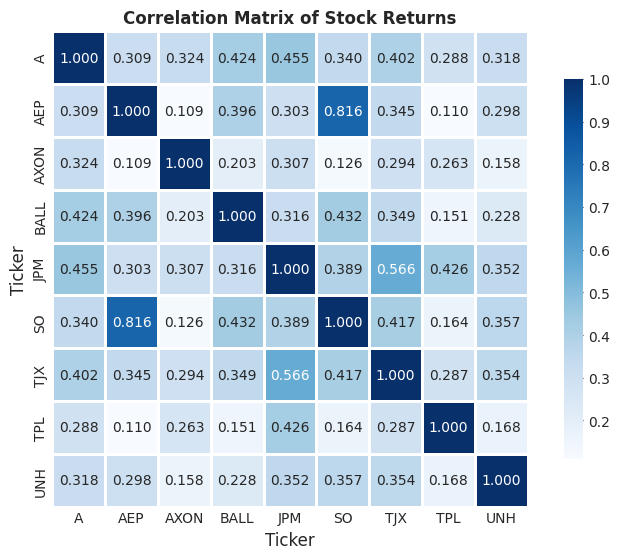

In [13]:
# Correlation heatmap
plt.figure(figsize=(7.7, 5.7))
sns.heatmap(log_returns.corr(), cmap='Blues', annot=True, fmt='.3f', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Stock Returns', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Portfolio Functions



construct a portfolio:

*  define a function that produces random weights $W_{i}$, with $\sum W_{i} = 1$, where the index $i$ refers to the different companies that compose our portfolio.

*  compute the portfolio annualized return as $\mu_{P}^{Annual} =  \sum W_{i} \mu_{i}^{Annual} $.

*  compute the portfolio yearly standar deviation as $\sigma_{P}^{Annual} =\sqrt{ \sum_{ij} W_{i}W_{j}\sigma{ij}^{Annual}}$

*  use Monte Carlo to generate 50,000 different, random weights $W_{i}$, which will render the same number of different portfolio allocations.

*  compute the Sharpe ratio: set the risk free return to 0.036 (1yr US treasury yield as of Dec 20 2025)



In [14]:
def initialize_weights(num_stocks):
    """Generate random portfolio weights that sum to 1"""
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    return weights

def calculate_portfolio_return(returns, weights):
    """Calculate annualized portfolio return"""
    portfolio_return = np.sum(returns.mean() * weights) * TRADING_DAYS
    return portfolio_return

def calculate_portfolio_volatility(returns, weights):
    """Calculate annualized portfolio volatility (standard deviation)"""
    portfolio_volatility = np.sqrt(
        np.dot(weights.T, np.dot(returns.cov() * TRADING_DAYS, weights))
    )
    return portfolio_volatility

def calculate_sharpe_ratio(portfolio_return, portfolio_volatility, risk_free_rate=RISK_FREE_RATE):
    """Calculate Sharpe ratio"""
    return (portfolio_return - risk_free_rate) / portfolio_volatility

def portfolio_statistics(weights, returns):
    """Calculate portfolio return, volatility, and Sharpe ratio"""
    portfolio_return = calculate_portfolio_return(returns, weights)
    portfolio_volatility = calculate_portfolio_volatility(returns, weights)
    sharpe_ratio = calculate_sharpe_ratio(portfolio_return, portfolio_volatility)
    return np.array([portfolio_return, portfolio_volatility, sharpe_ratio])

### Test Single Portfolio

In [15]:
test_weights = initialize_weights(len(STOCKS))
print('Random Weights:', test_weights.round(3))
print('Expected Portfolio Return:', calculate_portfolio_return(log_returns, test_weights).round(4))
print('Expected Portfolio Volatility:', calculate_portfolio_volatility(log_returns, test_weights).round(4))

Random Weights: [0.068 0.139 0.02  0.158 0.123 0.163 0.131 0.184 0.014]
Expected Portfolio Return: 0.1506
Expected Portfolio Volatility: 0.2087


## 6. Monte Carlo Simulation

In [16]:
def generate_portfolios(returns, num_portfolios=NUM_PORTFOLIOS):
    """
    Generate random portfolios using Monte Carlo simulation
    Returns arrays of portfolio returns and volatilities
    """
    num_stocks = len(returns.columns)
    portfolio_returns = np.zeros(num_portfolios)
    portfolio_volatilities = np.zeros(num_portfolios)
    
    for i in range(num_portfolios):
        weights = initialize_weights(num_stocks)
        portfolio_returns[i] = calculate_portfolio_return(returns, weights)
        portfolio_volatilities[i] = calculate_portfolio_volatility(returns, weights)
    
    return portfolio_returns, portfolio_volatilities

def plot_efficient_frontier(returns, volatilities, optimum_stats=None):
    """Plot the efficient frontier with optional optimum portfolio"""
    sharpe_ratios = (returns - RISK_FREE_RATE) / volatilities
    
    plt.figure()
    scatter = plt.scatter(volatilities, returns, c=sharpe_ratios, 
                         marker='o', alpha=0.6, cmap='viridis')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Expected Volatility (Risk)', fontsize=12)
    plt.ylabel('Expected Return', fontsize=12)
    plt.title('Efficient Frontier - Monte Carlo Simulation', fontsize=14, fontweight='bold')
    colorbar = plt.colorbar(scatter, label='Sharpe Ratio')
    
    # Plot optimal portfolio if provided
    if optimum_stats is not None:
        plt.scatter(optimum_stats[1], optimum_stats[0], 
                   c='red', marker='*', s=500, edgecolors='black', 
                   linewidths=2, label='Optimal Portfolio', zorder=5)
        plt.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [17]:
# Generate portfolios
print(f'Generating {NUM_PORTFOLIOS:,} random portfolios...')
portfolio_returns, portfolio_volatilities = generate_portfolios(log_returns)
print('Monte Carlo simulation completed!')

Generating 50,000 random portfolios...
Monte Carlo simulation completed!


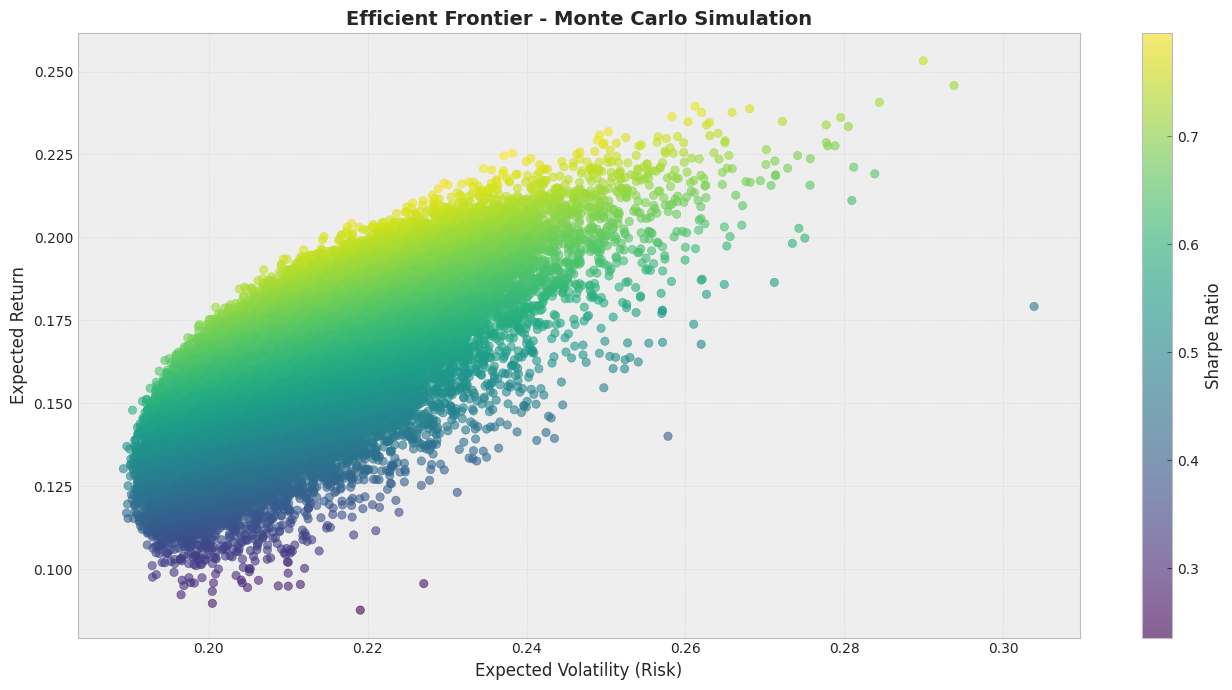

In [18]:
# Plot initial efficient frontier
plot_efficient_frontier(portfolio_returns, portfolio_volatilities)

## 7. Portfolio Optimization

In [19]:
def negative_sharpe_ratio(weights, returns):
    """Objective function to minimize (negative Sharpe ratio)"""
    return -portfolio_statistics(weights, returns)[2]

def optimize_portfolio(returns):
    """
    Optimize portfolio to maximize Sharpe ratio
    Returns optimization result
    """
    num_stocks = len(returns.columns)
    initial_weights = initialize_weights(num_stocks)
    
    # Constraints: weights sum to 1
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # Bounds: each weight between 0 and 1
    bounds = tuple((0, 1) for _ in range(num_stocks))
    
    # Optimization
    result = optimization.minimize(
        fun=negative_sharpe_ratio,
        x0=initial_weights,
        args=(returns,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    return result

In [20]:
# Optimize portfolio
print('Optimizing portfolio...')
optimum = optimize_portfolio(log_returns)

if optimum.success:
    print('Optimization successful!')
else:
    print('Optimization warning:', optimum.message)

Optimizing portfolio...
Optimization successful!


## 8. Optimal Portfolio Results

In [21]:
def display_optimal_portfolio(optimum, returns, stocks=STOCKS):
    """Display optimal portfolio weights and statistics"""
    optimal_weights = optimum.x
    stats = portfolio_statistics(optimal_weights, returns)
    
    print('\n' + '=' * 60)
    print('OPTIMAL PORTFOLIO ALLOCATION')
    print('=' * 60)
    
    for i, stock in enumerate(stocks):
        print(f'{stock:6s}: {optimal_weights[i]:7.2%}')
    
    print('\n' + '=' * 60)
    print('PORTFOLIO PERFORMANCE METRICS')
    print('=' * 60)
    print(f'Expected Annual Return:     {stats[0]:7.2%}')
    print(f'Expected Annual Volatility: {stats[1]:7.2%}')
    print(f'Sharpe Ratio:               {stats[2]:7.3f}')
    print('=' * 60 + '\n')
    
    return optimal_weights, stats

In [22]:
optimal_weights, optimal_stats = display_optimal_portfolio(optimum, log_returns)


OPTIMAL PORTFOLIO ALLOCATION
AEP   :   0.00%
TPL   :   0.00%
BALL  :  32.54%
A     :   0.00%
SO    :  12.93%
TJX   :  25.04%
UNH   :  21.62%
AXON  :   7.88%
JPM   :   0.00%

PORTFOLIO PERFORMANCE METRICS
Expected Annual Return:      24.04%
Expected Annual Volatility:  25.00%
Sharpe Ratio:                 0.817



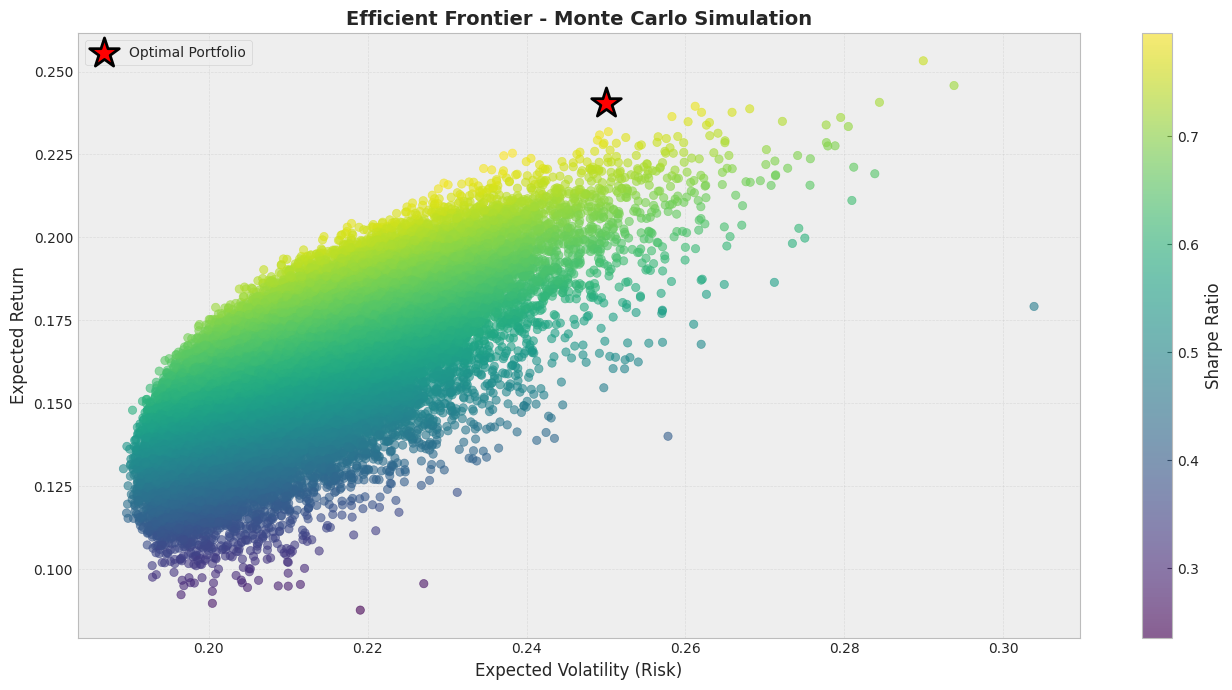

In [23]:
# Plot efficient frontier with optimal portfolio
plot_efficient_frontier(portfolio_returns, portfolio_volatilities, optimal_stats)

## 9. Portfolio Weights Visualization

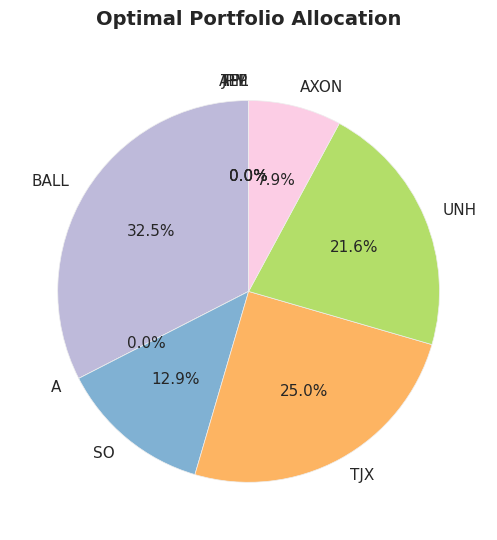

In [24]:
# Pie chart of optimal weights
plt.figure(figsize=(7.7, 5.5))
colors = plt.cm.Set3(range(len(STOCKS)))
wedges, texts, autotexts = plt.pie(optimal_weights, labels=STOCKS, autopct='%1.1f%%', 
                                     startangle=90, colors=colors, textprops={'fontsize': 11})
plt.title('Optimal Portfolio Allocation', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

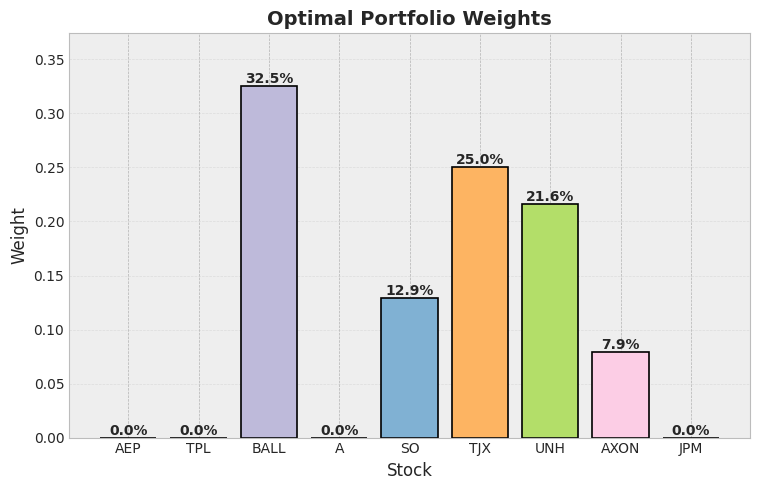

In [25]:
# Bar chart of optimal weights
plt.figure(figsize=(7.7, 5))
bars = plt.bar(STOCKS, optimal_weights, color=colors, edgecolor='black', linewidth=1.2)
plt.ylabel('Weight', fontsize=12)
plt.xlabel('Stock', fontsize=12)
plt.title('Optimal Portfolio Weights', fontsize=14, fontweight='bold')
plt.ylim(0, max(optimal_weights) * 1.15)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Optimal Portfolio Summary Statistics

In [26]:
def create_summary_table(stocks, optimal_weights, log_returns):
    """Create a summary table with stock statistics and optimal weights"""
    summary_data = {
        'Stock': stocks,
        'Optimal Weight': optimal_weights,
        'Annual Return': log_returns.mean() * TRADING_DAYS,
        'Annual Volatility': log_returns.std() * np.sqrt(TRADING_DAYS),
        'Sharpe Ratio': (log_returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (log_returns.std() * np.sqrt(TRADING_DAYS))
    }
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Optimal Weight', ascending=False)
    
    return summary_df

In [27]:
summary_table = create_summary_table(STOCKS, optimal_weights, log_returns)
print('\n' + '=' * 80)
print('INDIVIDUAL STOCK STATISTICS WITH OPTIMAL WEIGHTS')
print('=' * 80)
print(summary_table.to_string(index=False))
print('=' * 80)


INDIVIDUAL STOCK STATISTICS WITH OPTIMAL WEIGHTS
Stock  Optimal Weight  Annual Return  Annual Volatility  Sharpe Ratio
 BALL    3.253548e-01       0.370824           0.492174      0.680296
  TJX    2.504214e-01       0.135842           0.239654      0.416609
  UNH    2.161592e-01       0.192183           0.286005      0.546086
   SO    1.292693e-01       0.195261           0.298846      0.532921
 AXON    7.879530e-02       0.240191           0.498218      0.409842
    A    6.918948e-17       0.033227           0.308095     -0.009000
  JPM    5.352595e-17       0.059081           0.329570      0.070035
  AEP    2.773840e-17       0.113012           0.293208      0.262653
  TPL    0.000000e+00       0.100368           0.228482      0.281719


#### Github Reference:

- https://github.com/aldodec/Monte-Carlo-Portfolio-Allocation/tree/master